# Imports

In [ ]:
import mesa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Functions

In [13]:
# Contribution function
def contribution(cur_prestige, all_prestige):
    # Top 10% of the distribution
    top_pres = np.quantile(all_prestige, 0.9)
    # Bottom 50% of the distribution
    low_pres = np.quantile(all_prestige, 0.5)

    if top_pres == low_pres:
        return 0.0
    else:
        # If current prestige above 90%
        if cur_prestige >= top_pres:
            # return cur_prestige
            return 1
        # If current prestige below 50%
        elif cur_prestige <= low_pres:
            # return -cur_prestige
            return -1
        # If current prestige between 50% and 90%
        else:
            return 0.0

# Normalization function
def normalize(reputations):
    if reputations.max() == 0:
        return reputations
    else:
        return reputations / reputations.max()

# Classes

In [14]:
class JournalAgent(mesa.Agent):
    def __init__(self, model, is_oa, cost, ethics, reputation, acceptance_rate):
        super().__init__(model)
        self.is_oa = is_oa
        self.cost = cost
        self.ethics = ethics
        self.reputation = reputation
        self.acceptance_rate = acceptance_rate

        # Step-specific metrics
        self.revenue_this_step = 0
        self.papers_this_step = 0

    def step(self):
        """At the end of a step, reset per-step counters."""
        self.revenue_this_step = 0
        self.papers_this_step = 0

In [15]:
class ResearcherGroupAgent(mesa.Agent):
    def __init__(self, model, prestige, weight_prestige, weight_ethics):
        super().__init__(model)
        self.prestige = prestige
        self.weight_prestige = weight_prestige
        self.weight_ethics = weight_ethics

    def submit_paper(self):
        """Score journals, sort them, and attempt to publish a paper."""
        # Get all journal agents from the model
        journals = [agent for agent in self.model.agents if isinstance(agent, JournalAgent)]

        # Extract current reputation and ethics scores for scoring
        reputations = np.array([j.reputation for j in journals])
        ethics_scores = np.array([j.ethics for j in journals])

        # Calculate scores for all journals based on this group's preferences
        journal_scores = (
                self.weight_prestige * (normalize(reputations)) +
                self.weight_ethics * ethics_scores
        )

        # Sort journals by score in descending order
        # We sort the actual journal objects based on the scores
        sorted_journals = sorted(zip(journals, journal_scores), key=lambda x: x[1], reverse=True)

        # Submission loop
        for journal, score in sorted_journals:
            # Attempt to publish in the current journal
            if self.rng.uniform(0, 1) < journal.acceptance_rate:
                # --- Publication successful ---
                # Update journal state
                journal.reputation += (self.model.weight_contribution *
                                       contribution(self.prestige, self.model.all_group_prestiges))
                if journal.reputation < 0:
                    journal.reputation = 0
                journal.revenue_this_step += journal.cost
                journal.papers_this_step += 1

                # Update this agent's state
                self.prestige += contribution(journal.reputation, self.model.all_journal_reputations)
                if self.prestige < 0:
                    self.prestige = 0

                # Stop submission process for this step
                break

    def step(self):
        """The agent's action during a simulation step."""
        self.submit_paper()

In [16]:
class PublishingModel(mesa.Model):
    """The main model that runs the simulation."""
    def __init__(self, n_groups, n_journals, weight_contribution=0.1, weight_prestige_max=0.1, seed=None):
        super().__init__(seed=seed)
        self.n_groups = n_groups
        self.n_journals = n_journals
        self.weight_contribution = weight_contribution

        # Create Journal Agents
        JournalAgent.create_agents(
            self,
            n_journals,
            is_oa=self.rng.choice([0, 1], size=n_journals),
            cost=self.rng.choice([50, 500, 5000], size=n_journals),
            ethics=self.rng.uniform(0, 1, size=n_journals),
            reputation=self.rng.exponential(scale=1/0.1, size=n_journals),
            acceptance_rate=self.rng.uniform(0, 1, size=n_journals)
        )

        # Create Researcher Group Agents
        weight_prestige = self.rng.uniform(0, weight_prestige_max, size=n_groups)
        ResearcherGroupAgent.create_agents(
            self,
            n_groups,
            prestige=self.rng.exponential(scale=1/0.01, size=n_groups),
            weight_prestige=weight_prestige,
            weight_ethics=1 - weight_prestige
        )

        # Set up DataCollector
        agent_reporters = {
            "Type": lambda a: a.__class__.__name__,
            "Prestige": lambda a: getattr(a, 'prestige', None),
            "Reputation": lambda a: getattr(a, 'reputation', None),
            "NPapers": lambda a: getattr(a, 'papers_this_step', None),
            "Profit": lambda a: getattr(a, 'revenue_this_step', None),
            "Ethics": lambda a: getattr(a, 'ethics', None),
            "Cost": lambda a: getattr(a, 'cost', None),
            "OA": lambda a: getattr(a, 'is_oa', None)
        }
        self.datacollector = mesa.DataCollector(agent_reporters=agent_reporters)

    @property
    def all_group_prestiges(self):
        """Helper property to get all current group prestiges."""
        return np.array([a.prestige for a in self.agents if isinstance(a, ResearcherGroupAgent)])

    @property
    def all_journal_reputations(self):
        """Helper property to get all current journal reputations."""
        return np.array([a.reputation for a in self.agents if isinstance(a, JournalAgent)])

    def step(self):
        """Execute one time step of the simulation."""
        self.agents_by_type[JournalAgent].shuffle_do("step")
        self.agents_by_type[ResearcherGroupAgent].shuffle_do("step")
        self.datacollector.collect(self)

# Run simulations

In [17]:
result = mesa.batch_run(
    PublishingModel,
    number_processes=1,
    iterations=10,
    data_collection_period=1,
    parameters={
        "n_journals": 10,
        "n_groups": 100,
        "weight_prestige_max": [1, 0.1],
    },
    max_steps=100
)

result = pd.DataFrame(result)

result['Ethics Group'] = np.where(result['Ethics'] < 0.5, 'Ethics < 0.5', 'Ethics >= 0.5')

  0%|          | 0/20 [00:00<?, ?it/s]

# Results

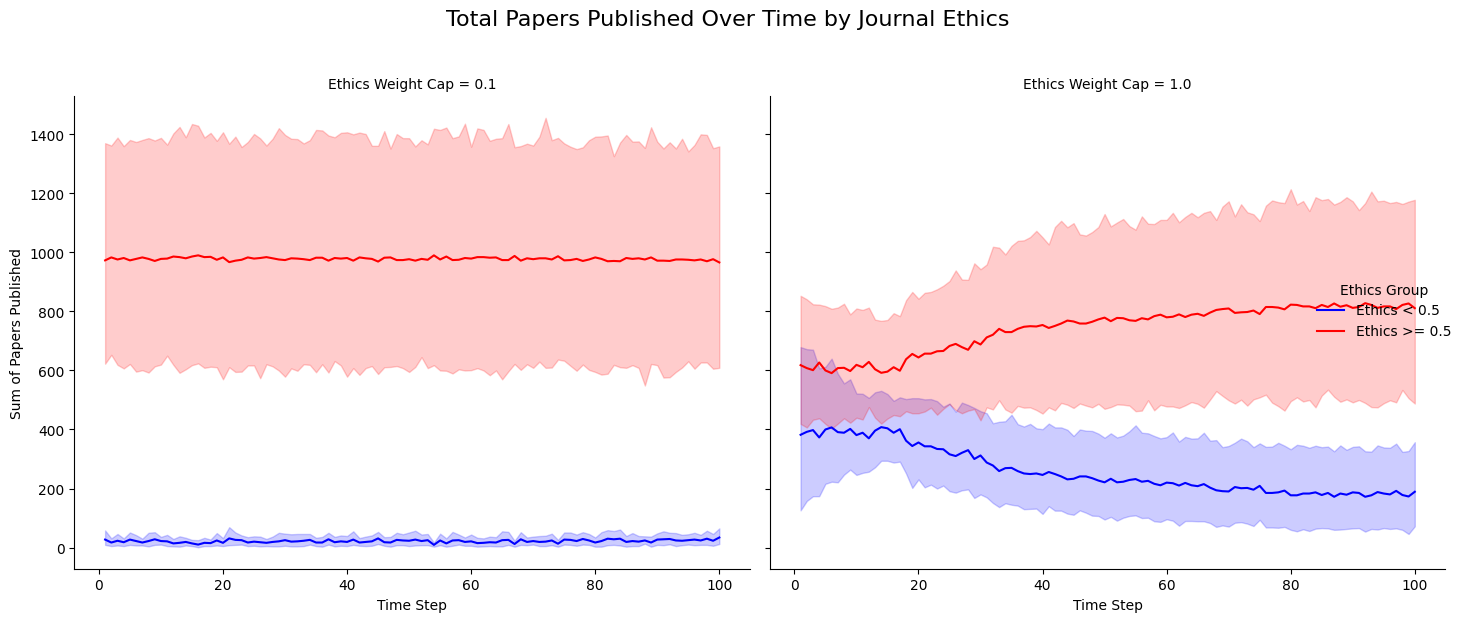

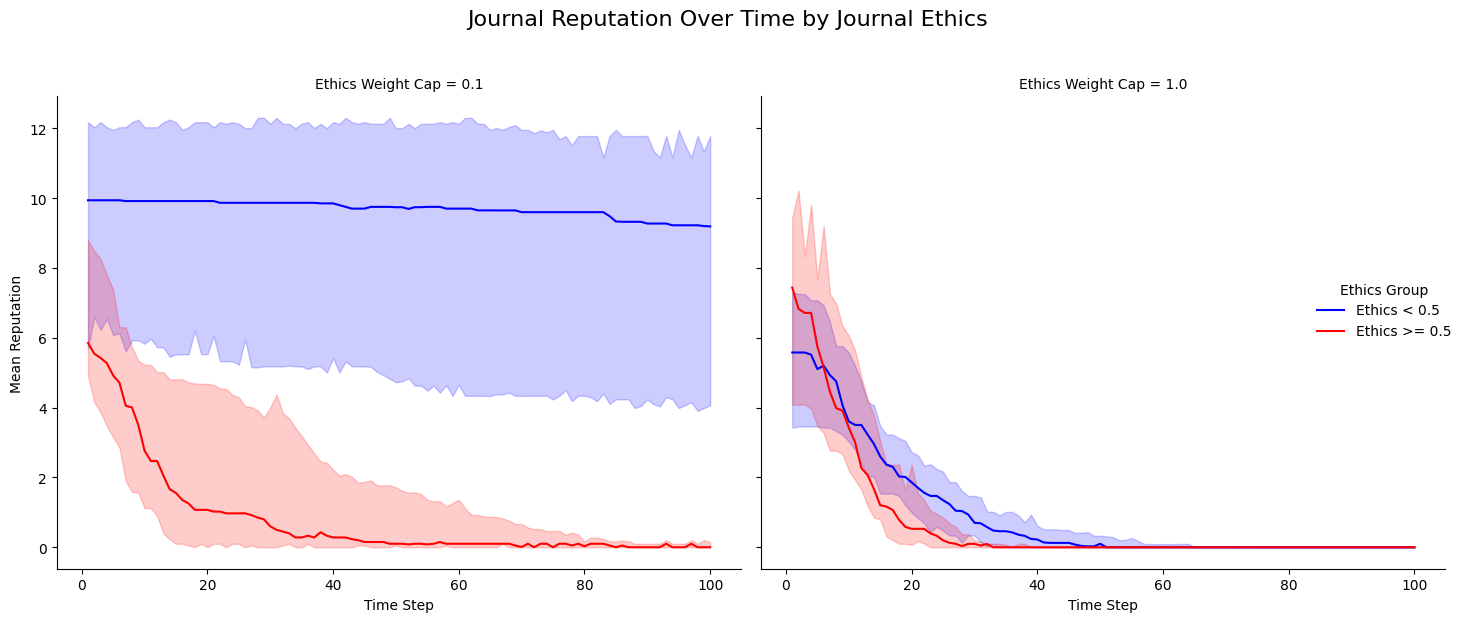

In [18]:
g = sns.relplot(
    data=result[result["Type"] == "JournalAgent"],
    x='Step',
    y='NPapers',
    hue='Ethics Group',
    col='weight_prestige_max',
    kind='line',
    estimator=np.sum,
    palette={
            'Ethics >= 0.5': 'red',
            'Ethics < 0.5': 'blue'
        },
    errorbar='ci',
    height=6,
    aspect=1.1
)
g.fig.suptitle('Total Papers Published Over Time by Journal Ethics', fontsize=16, y=1.03)
g.set_titles("Ethics Weight Cap = {col_name}")
g.set_axis_labels("Time Step", "Sum of Papers Published")

plt.tight_layout()
plt.show()

g = sns.relplot(
    data=result[result["Type"] == "JournalAgent"],
    x='Step',
    y='Reputation',
    hue='Ethics Group',
    col='weight_prestige_max',
    kind='line',
    estimator=np.median,
    palette={
            'Ethics >= 0.5': 'red',
            'Ethics < 0.5': 'blue'
        },
    errorbar='ci',
    height=6,
    aspect=1.1
)
g.fig.suptitle('Journal Reputation Over Time by Journal Ethics', fontsize=16, y=1.03)
g.set_titles("Ethics Weight Cap = {col_name}")
g.set_axis_labels("Time Step", "Mean Reputation")

plt.tight_layout()
plt.show()

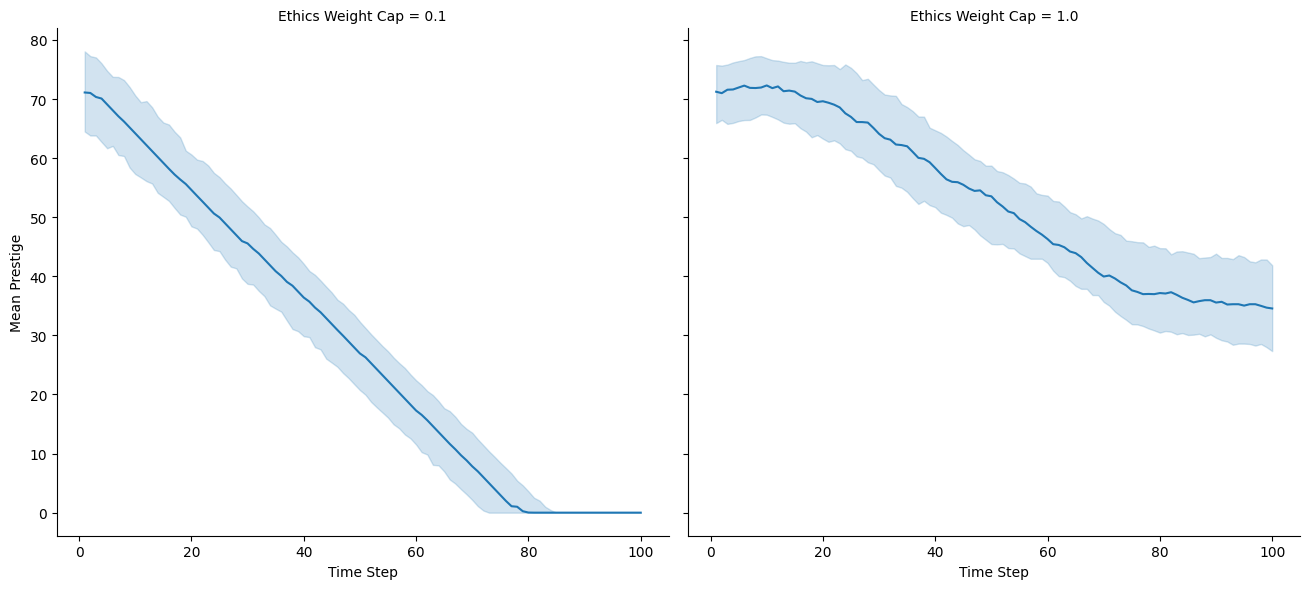

In [20]:
g = sns.relplot(
    data=result[result["Type"] == "ResearcherGroupAgent"],
    x='Step',
    y='Prestige',
    kind='line',
    estimator=np.median,
    errorbar='ci',
    height=6,
    aspect=1.1,
    col='weight_prestige_max',
)
g.set_axis_labels("Time Step", "Mean Prestige")
g.set_titles("Ethics Weight Cap = {col_name}")

plt.tight_layout()
plt.show()